In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from mlxtend.classifier import StackingClassifier
import lightgbm
import catboost

%load_ext autoreload
%autoreload 2
import classification_model_evaluation as model_eval

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load pixel data
RGB_train = pickle.load(open('RGB_train_reduce.pickle', 'rb'))
RGB_test = pickle.load(open('RGB_test_reduce.pickle', 'rb'))
RGB_labels_train = pickle.load(open('RGB_train_labels.pickle', 'rb'))
RGB_labels_test = pickle.load(open('RGB_test_labels.pickle', 'rb'))

print(RGB_train.shape, RGB_test.shape)

(21600, 120) (5400, 120)


In [3]:
# load Dense SIFT features data
dsift_train = pickle.load(open('dsift_train_reduce.pickle', 'rb'))
dsift_test = pickle.load(open('dsift_test_reduce.pickle', 'rb'))
dsift_labels_train = pickle.load(open('dsift_train_labels.pickle', 'rb'))
dsift_labels_test = pickle.load(open('dsift_test_labels.pickle', 'rb'))

print(dsift_train.shape, dsift_test.shape)

(21600, 160) (5400, 160)


In [4]:
# split training data: 60-20-20 train-validation-test
RGB_train, RGB_val, RGB_labels_train, RGB_labels_val = train_test_split(RGB_train, RGB_labels_train, 
                                                                        test_size = 0.25, random_state = 423, 
                                                                        stratify = RGB_labels_train)

In [5]:
# build XGBoost classifier
gbm = xgb.XGBClassifier( 
                       n_estimators = 500, # arbitrary since using early stopping
                       max_depth = 3,
                       objective = "multi:softmax",  # multiclass loss
                       learning_rate = 0.1, 
                       subsample = 1,
                       min_child_weight = 1,
                       colsample_bytree = 0.8,
                       n_jobs = -1,
                       random_state = 423
                      )

eval_set = [(RGB_train, RGB_labels_train), (RGB_val, RGB_labels_val)]   # tracking train/validation error

gbm.fit( 
        RGB_train, RGB_labels_train, 
        eval_set = eval_set,
        eval_metric = 'merror',
        early_stopping_rounds = 30,  # early stopping with train/validation set using multiclass error for speed
        verbose = False
       )

accuracy_score(RGB_labels_test, gbm.predict(RGB_test, ntree_limit = gbm.best_ntree_limit))

0.6972222222222222

In [6]:
gbm_metrics = model_eval.compute_metrics(gbm, RGB_test, RGB_labels_test)
gbm_metrics

{'accuracy': 0.6972222222222222,
 'f1_score': 0.6925000775991521,
 'precision': 0.6936970714997203,
 'recall': 0.6972222222222222,
 'specificity': nan,
 'log_loss': 0.892391366132382,
 'auc': 0.9454756503684808}

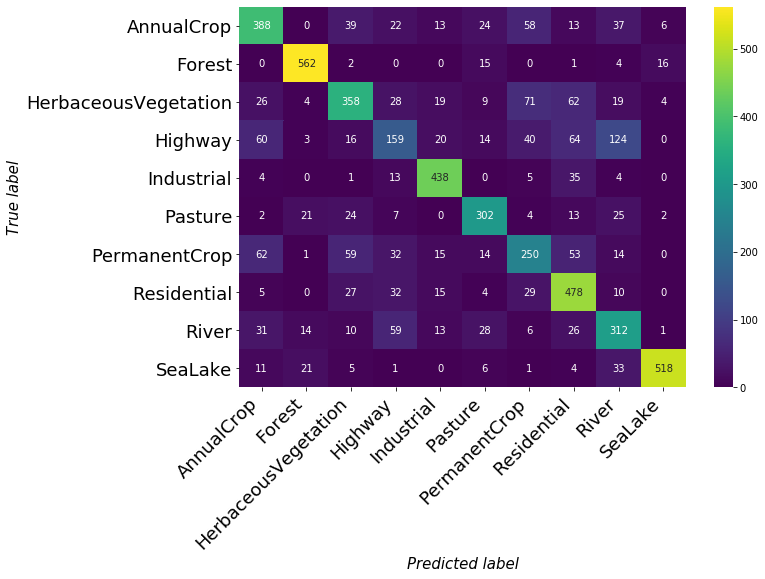

In [7]:
# confusion matrix for XGBoost classifier
labels = np.unique(RGB_labels_test)
gbm_cm = confusion_matrix(RGB_labels_test, gbm.predict(RGB_test, ntree_limit = gbm.best_ntree_limit), 
                          labels = labels)
model_eval.print_confusion_matrix(gbm_cm, labels)

In [8]:
# split dsift training set: 60-20-20 train-validation-test
dsift_train, dsift_val, dsift_labels_train, dsift_labels_val = \
    train_test_split(dsift_train, dsift_labels_train, test_size = 0.25, 
                     random_state = 423, stratify = dsift_labels_train)

In [10]:
# XGBoost classifier for dense SIFT features
gbm2 = xgb.XGBClassifier( 
                       n_estimators = 500, 
                       max_depth = 3,
                       objective = "multi:softmax",
                       learning_rate = 0.1, 
                       subsample = 1,
                       min_child_weight = 1,
                       colsample_bytree = 0.8,
                       n_jobs = -1,
                       random_state = 423
                      )

eval_set2 = [(dsift_train, dsift_labels_train), (dsift_val, dsift_labels_val)]  

gbm2.fit( 
        dsift_train, dsift_labels_train, 
        eval_set = eval_set2,
        eval_metric = 'merror',
        early_stopping_rounds = 30,
        verbose = False
        )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
       nthread=None, objective='multi:softprob', random_state=423,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [11]:
gbm_metrics2 = model_eval.compute_metrics(gbm2, dsift_test, dsift_labels_test)
gbm_metrics2

{'accuracy': 0.5272222222222223,
 'f1_score': 0.5196911169176595,
 'precision': 0.5215706328978561,
 'recall': 0.5272222222222223,
 'specificity': nan,
 'log_loss': 1.3495884210905233,
 'auc': 0.8898596044028724}

In [13]:
print(gbm.best_ntree_limit, gbm2.best_ntree_limit)  # best no. of trees for both models

254 427


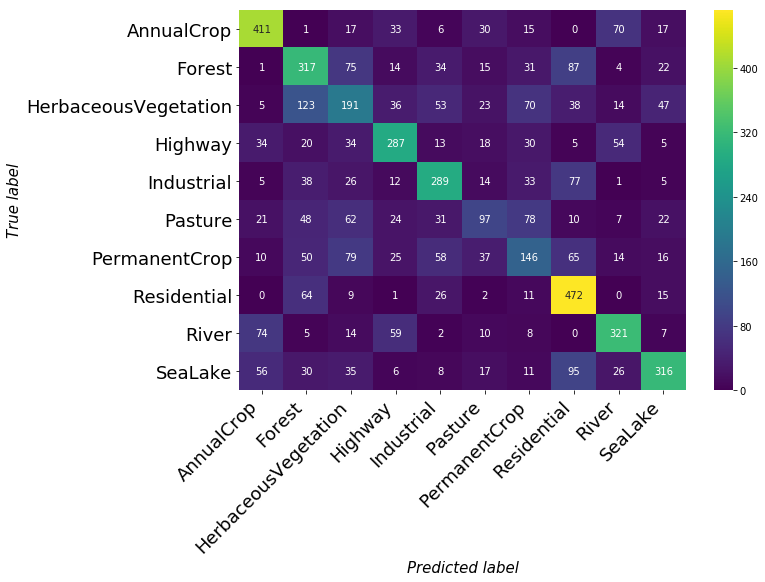

In [14]:
# dsift XGBoost model confusion matrix
gbm_cm2 = confusion_matrix(dsift_labels_test, gbm2.predict(dsift_test, ntree_limit = gbm2.best_ntree_limit), 
                          labels = labels)
model_eval.print_confusion_matrix(gbm_cm2, labels)

In [11]:
def xgb_tune(X_train, y_train, X_test, y_test, max_depth = 3, learning_rate = 0.1, subsample = 1, 
             min_child_weight = 1, colsample_bytree = 0.8, gamma = 0, reg_alpha = 0, reg_lambda = 1, 
             random_state = 423):
    """
    Build XGBoost classifier with specified training parameters and report test set accuracy.
    
    Parameters
    ----------
    X_train: ndarray (array-like)
        Training set predictors
    y_train: ndarray or list
        Training set labels
    X_test: ndarray (array-like)
        Test set predictors
    y_test: ndarray or list
        Test set labels
    max_depth: int
    learning_rate: float
    subsample: float in range (0, 1)
    min_child_weight: int
    colsample_bytree: float in range (0, 1)
    gamma: float
    reg_alpha: float
    reg_lambda: float
    random_state: int
    
    Returns
    -------
    float
        Test set accuracy score
    """
    
    
    gbm = xgb.XGBClassifier( 
                           n_estimators = 3000, # arbitrarily large number since early stopping rounds used
                           max_depth = max_depth,
                           objective = "multi:softmax",
                           learning_rate = learning_rate, 
                           subsample = subsample,
                           min_child_weight = min_child_weight,
                           colsample_bytree = colsample_bytree, 
                           gamma = gamma, 
                           reg_alpha = reg_alpha, 
                           reg_lambda = reg_lambda,
                           n_jobs = -1,
                           random_state = random_state
                          )

    eval_set = [(X_train, y_train), (X_test, y_test)]   # tracking train/validation error

    gbm.fit( 
            X_train, y_train, 
            eval_set = eval_set,
            eval_metric = 'merror',
            early_stopping_rounds = 50,
            verbose = False
           )

    return accuracy_score(y_test, gbm.predict(X_test, ntree_limit = gbm.best_ntree_limit))

In [18]:
# previous accuracy (with max_depth = 3) was 0.688, tune max_depth
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 5)

0.6930864197530864

In [19]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7)

0.7014814814814815

In [20]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 9)

0.6997530864197531

In [29]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 8)

0.7002469135802469

In [30]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 6)

0.6955555555555556

In [21]:
# keep max_depth = 7 and tune subsample size (new best accuracy is 0.7015)
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.5)

0.6925925925925925

In [22]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75)

0.7051851851851851

In [23]:
# keep subsample = 0.75 and tune min_child_weight
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 3)

0.6967901234567901

In [24]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 5)

0.7032098765432099

In [25]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 7)

0.7004938271604938

In [26]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2)

0.705925925925926

In [31]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 4)

0.7044444444444444

In [32]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 6)

0.6995061728395062

In [27]:
# keep min_child_weight = 2 and tune colsample_bytree
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.5)

0.6958024691358025

In [28]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.7)

0.7064197530864198

In [33]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.9)

0.7064197530864198

In [34]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.6)

0.7012345679012346

In [35]:
# keep colsample_bytree = 0.7 and tune gamma (best accuracy is now 0.70642)
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.7, gamma = 0.2)

0.6992592592592592

In [36]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.7, gamma = 0.4)

0.6982716049382716

In [37]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.7, gamma = 0.1)

0.7024691358024692

In [38]:
# keep gamma = 0 and tune reg_alpha
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.7, gamma = 0, reg_alpha = 1)

0.6960493827160494

In [39]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.7, gamma = 0, reg_alpha = 0.1)

0.6948148148148148

In [40]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.7, gamma = 0, reg_alpha = 0.01)

0.7071604938271605

In [41]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.7, gamma = 0, reg_alpha = 0.001)

0.7

In [42]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.7, gamma = 0, reg_alpha = 0.005)

0.702962962962963

In [43]:
# keep reg_alpha = 0.01 and tune reg_lambda (best accuracy now 0.70716)
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.7, gamma = 0, reg_alpha = 0.01, reg_lambda = 0.1)

0.6982716049382716

In [44]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.7, gamma = 0, reg_alpha = 0.01, reg_lambda = 0)

0.7051851851851851

In [45]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.7, gamma = 0, reg_alpha = 0.01, reg_lambda = 0.01)

0.697283950617284

In [46]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.7, gamma = 0, reg_alpha = 0.01, reg_lambda = 0.001)

0.7004938271604938

In [47]:
xgb_tune(RGB_train, RGB_labels_train, RGB_val, RGB_labels_val, max_depth = 7, subsample = 0.75, 
         min_child_weight = 2, colsample_bytree = 0.7, gamma = 0, reg_alpha = 0.01, reg_lambda = 10)

0.7012345679012346

In [ ]:
# keep reg_lambda = 1

# Best model params:
    # max_depth = 7
    # subsample = 0.75
    # min_child_weight = 2
    # colsample_bytree = 0.7
    # gamma = 0
    # reg_alpha = 0.01
    # reg_lambda = 1
    
# Fit model to training set with learning_rate = 0.05 and test on test set
# Still using eval_set and early_stopping to get best number of trees

gbm_final = xgb.XGBClassifier( 
                           n_estimators = 10000, # arbitrarily large number since early stopping rounds used
                           max_depth = 7,
                           objective = "multi:softmax",
                           learning_rate = 0.05, 
                           subsample = 0.75,
                           min_child_weight = 2,
                           colsample_bytree = 0.7, 
                           gamma = 0, 
                           reg_alpha = 0.01, 
                           reg_lambda = 1,
                           n_jobs = -1,
                           random_state = 423
                          )

eval_set = [(RGB_train, RGB_labels_train), (RGB_val, RGB_labels_val)]  

gbm_final.fit( 
        RGB_train, RGB_labels_train, 
        eval_set = eval_set,
        eval_metric = 'merror',
        early_stopping_rounds = 50,
        verbose = False
       )

gbm_final_metrics = model_eval.compute_metrics(gbm_final, RGB_test, RGB_labels_test)
gbm_final_metrics

{'accuracy': 0.7111111111111111,
 'f1_score': 0.7056505321975093,
 'precision': 0.7081825429900683,
 'recall': 0.7111111111111111,
 'specificity': nan,
 'log_loss': 0.8351608229560541,
 'auc': 0.9510240218568909}

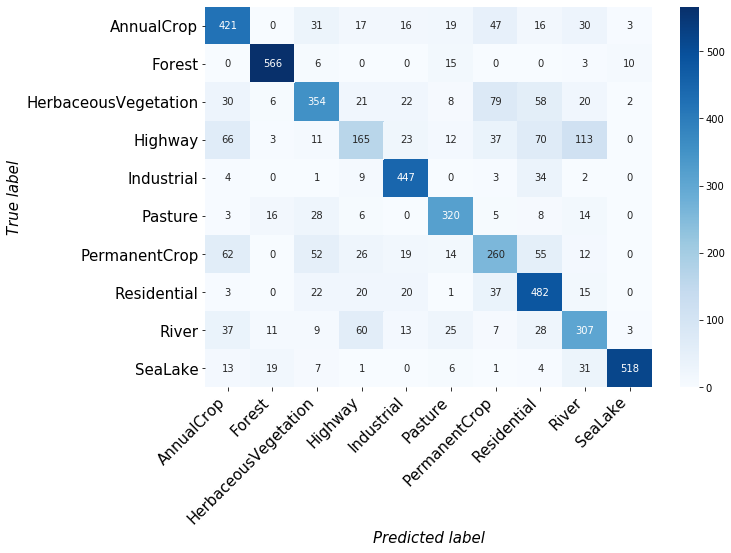

In [18]:
# best XGBoost classifier confusion matrix for pixel data
gbm_final_cm = confusion_matrix(RGB_labels_test, 
                                gbm_final.predict(RGB_test, ntree_limit = gbm_final.best_ntree_limit), 
                                labels = labels)
model_eval.print_confusion_matrix(gbm_final_cm, labels, fontsize = 15, file = 'xgb_RGB_cm.png')

In [19]:
# re-load full training sets and combine feature types into one array (pixel features and DSIFT features)
RGB_train = pickle.load(open('RGB_train_reduce.pickle', 'rb'))
RGB_labels_train = pickle.load(open('RGB_train_labels.pickle', 'rb'))
dsift_train = pickle.load(open('dsift_train_reduce.pickle', 'rb'))
dsift_labels_train = pickle.load(open('dsift_train_labels.pickle', 'rb'))

RGB_dsift_train = np.concatenate((RGB_train, dsift_train), axis = 1)
RGB_dsift_test = np.concatenate((RGB_test, dsift_test), axis = 1)
print(RGB_dsift_train.shape, RGB_dsift_test.shape)

(21600, 280) (5400, 280)


In [20]:
# split training set of new combined array: 60-20-20 train-validation-test
combine_train, combine_val, combine_labels_train, combine_labels_val = train_test_split(RGB_dsift_train, 
                                                                                        RGB_labels_train, 
                                                                                        test_size = 0.25, 
                                                                                        random_state = 423, 
                                                                                        stratify = RGB_labels_train)

In [21]:
# fit XGBoost classifier using optimized parameters to new combined dataset
gbm_combine = xgb.XGBClassifier( 
                           n_estimators = 10000, # arbitrarily large number since early stopping rounds used
                           max_depth = 7,
                           objective = "multi:softmax",
                           learning_rate = 0.05, 
                           subsample = 0.75,
                           min_child_weight = 2,
                           colsample_bytree = 0.7, 
                           gamma = 0, 
                           reg_alpha = 0.01, 
                           reg_lambda = 1,
                           n_jobs = -1,
                           random_state = 423
                          )

eval_set = [(combine_train, combine_labels_train), (combine_val, combine_labels_val)]  

gbm_combine.fit( 
        combine_train, combine_labels_train, 
        eval_set = eval_set,
        eval_metric = 'merror',
        early_stopping_rounds = 50,
        verbose = False
       )

gbm_combine_metrics = model_eval.compute_metrics(gbm_combine, RGB_dsift_test, RGB_labels_test)
gbm_combine_metrics  # accuracy went up 10%!

{'accuracy': 0.807962962962963,
 'f1_score': 0.8069975713683917,
 'precision': 0.8083286034915578,
 'recall': 0.807962962962963,
 'specificity': nan,
 'log_loss': 0.5411649164930735,
 'auc': 0.9796204658604182}

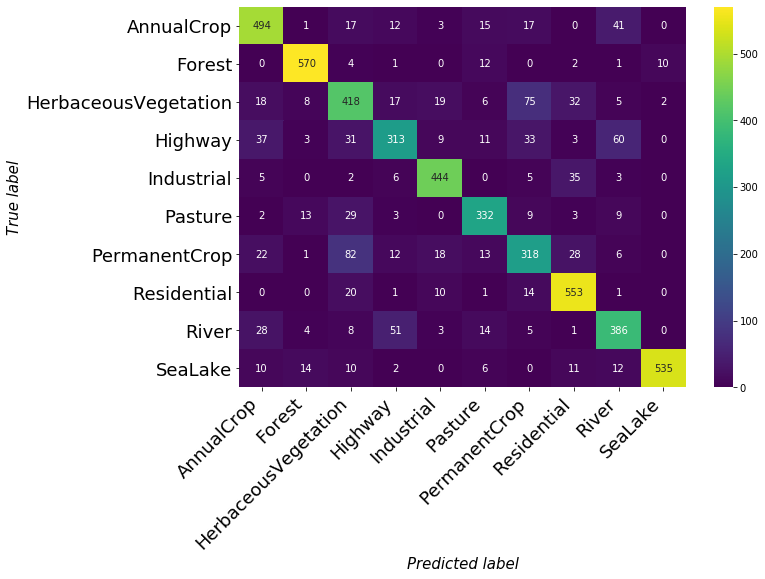

In [40]:
# confusion matrix for combined dataset
gbm_combine_cm = confusion_matrix(RGB_labels_test, 
                                  gbm_combine.predict(RGB_dsift_test, ntree_limit = gbm_combine.best_ntree_limit), 
                                  labels = labels)
model_eval.print_confusion_matrix(gbm_combine_cm, labels)

In [22]:
# fit Naive Bayes model to combined dataset
nb_combine = GaussianNB().fit(RGB_dsift_train, RGB_labels_train)
nb_combine_metrics = model_eval.compute_metrics(nb_combine, RGB_dsift_test, RGB_labels_test)
nb_combine_metrics

{'accuracy': 0.5312962962962963,
 'f1_score': 0.5330851697979936,
 'precision': 0.5823934479598777,
 'recall': 0.5312962962962963,
 'specificity': nan,
 'log_loss': 8.37105062810084,
 'auc': 0.8838527713844798}

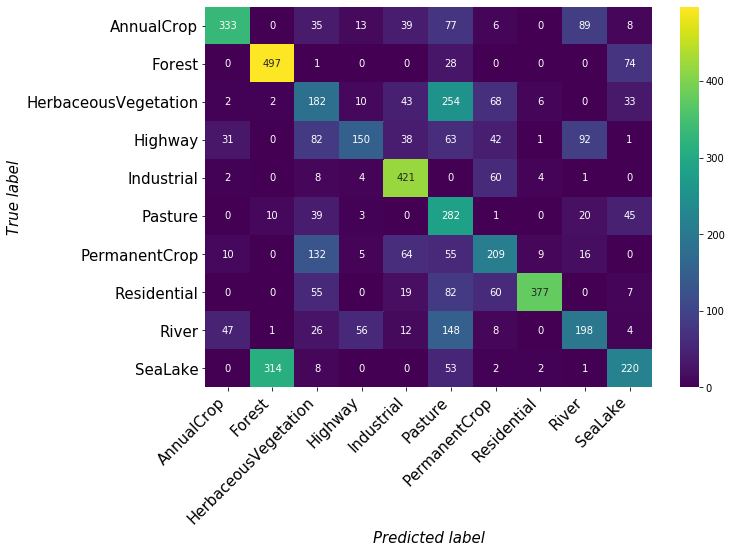

In [28]:
# Naive Bayes confusion matrix
nb_combine_cm = confusion_matrix(RGB_labels_test, nb_combine.predict(RGB_dsift_test), labels = labels)
model_eval.print_confusion_matrix(nb_combine_cm, labels, fontsize = 15, file = 'nb_combine_cm.png')

In [23]:
# fit kNN classifier to combined dataset
knn_combine = KNeighborsClassifier(n_neighbors = 4, n_jobs = -1).fit(RGB_dsift_train, RGB_labels_train)
knn_combine_metrics = model_eval.compute_metrics(knn_combine, RGB_dsift_test, RGB_labels_test)
knn_combine_metrics

{'accuracy': 0.37166666666666665,
 'f1_score': 0.3368700437666415,
 'precision': 0.5111140930853457,
 'recall': 0.37166666666666665,
 'specificity': nan,
 'log_loss': 15.51959010043958,
 'auc': 0.722050732867221}

In [24]:
# fit logistic regression to combined dataset
logistic_combine = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)\
    .fit(RGB_dsift_train, RGB_labels_train)
logistic_combine_metrics = model_eval.compute_metrics(logistic_combine, RGB_dsift_test, RGB_labels_test)
logistic_combine_metrics

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


{'accuracy': 0.6366666666666667,
 'f1_score': 0.6326030353402663,
 'precision': 0.6336263676809163,
 'recall': 0.6366666666666667,
 'specificity': nan,
 'log_loss': 1.0316159898087995,
 'auc': 0.9385057736520535}

In [25]:
# fit decision tree to combined dataset
tree_combine = DecisionTreeClassifier(random_state = 423).fit(RGB_dsift_train, RGB_labels_train)
tree_combine_metrics = model_eval.compute_metrics(tree_combine, RGB_dsift_test, RGB_labels_test)
tree_combine_metrics

{'accuracy': 0.5507407407407408,
 'f1_score': 0.5496664807522728,
 'precision': 0.5495475842090535,
 'recall': 0.5507407407407408,
 'specificity': nan,
 'log_loss': 15.516865098898771,
 'auc': 0.7502951530612245}

In [26]:
# fit random forest to combined dataset- parameters selected from previous grid search
RF_combine = RandomForestClassifier(
                            n_estimators = 500, 
                            max_features = 25, 
                            min_samples_split = 10, 
                            bootstrap = False, 
                            n_jobs = -1, 
                            random_state = 423
                           )

RF_combine.fit(RGB_dsift_train, RGB_labels_train)
RF_combine_metrics = model_eval.compute_metrics(RF_combine, RGB_dsift_test, RGB_labels_test)
RF_combine_metrics

{'accuracy': 0.7485185185185185,
 'f1_score': 0.7425105337069502,
 'precision': 0.7498744172921347,
 'recall': 0.7485185185185185,
 'specificity': nan,
 'log_loss': 1.0122755748679153,
 'auc': 0.9645275586419754}

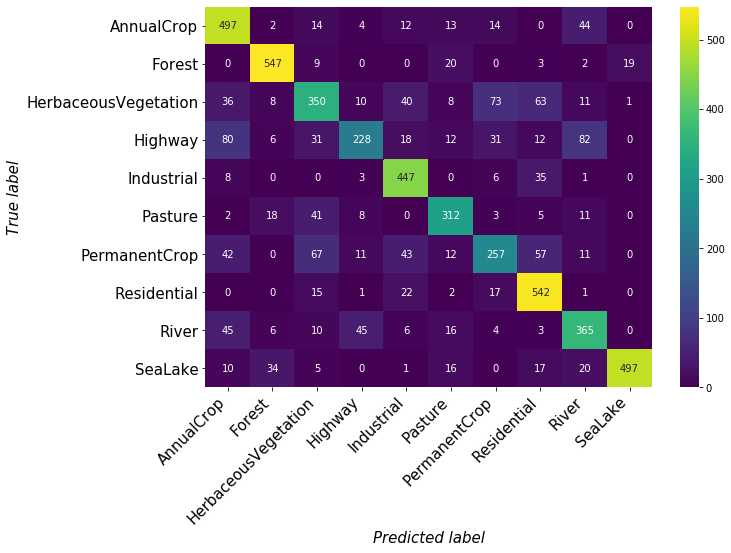

In [29]:
# random forest confusion matrix
RF_combine_cm = confusion_matrix(RGB_labels_test, RF_combine.predict(RGB_dsift_test), labels = labels)
model_eval.print_confusion_matrix(RF_combine_cm, labels, fontsize = 15, file = 'RF_combine_cm.png')

In [25]:
# fit AdaBoost classifier to combined dataset
ada_combine = AdaBoostClassifier(
                                n_estimators = 500, 
                                learning_rate = 0.1, 
                                algorithm = 'SAMME.R', 
                                random_state = 423
                                )

ada_combine.fit(RGB_dsift_train, RGB_labels_train)
ada_combine_metrics = model_eval.compute_metrics(ada_combine, RGB_dsift_test, RGB_labels_test)
ada_combine_metrics

{'accuracy': 0.225,
 'f1_score': 0.22311749184089136,
 'precision': 0.37678473880678753,
 'recall': 0.225,
 'specificity': nan,
 'log_loss': 2.1475151048886247,
 'auc': 0.7833764878432855}

In [27]:
# fit extra trees model to combined dataset
extratrees_combine = ExtraTreesClassifier(
                                        n_estimators = 500, 
                                        min_samples_split = 10, 
                                        max_features = 25, 
                                        bootstrap = False, 
                                        n_jobs = -1, 
                                        random_state = 423
                                        )

extratrees_combine.fit(RGB_dsift_train, RGB_labels_train)
extra_combine_metrics = model_eval.compute_metrics(extratrees_combine, RGB_dsift_test, RGB_labels_test)
extra_combine_metrics

{'accuracy': 0.7422222222222222,
 'f1_score': 0.730959921468019,
 'precision': 0.7510966206738379,
 'recall': 0.7422222222222222,
 'specificity': nan,
 'log_loss': 1.1886298737636274,
 'auc': 0.958909731324011}

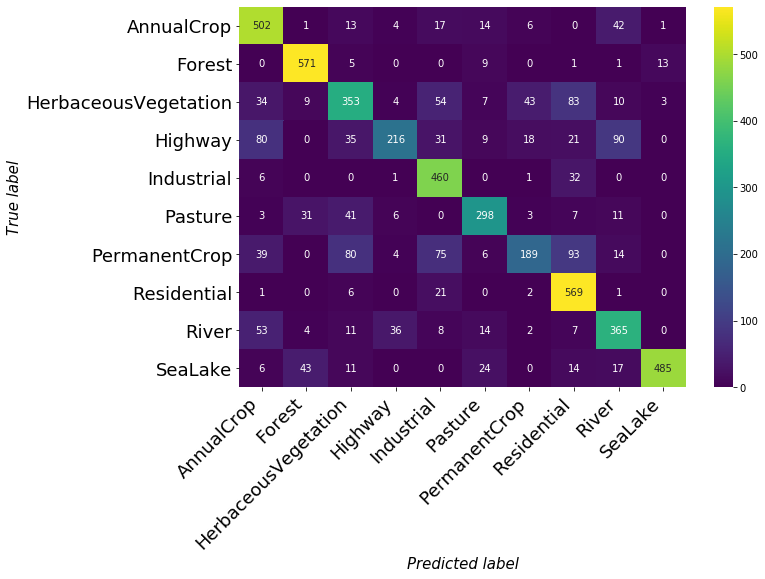

In [50]:
# extra trees confusion matrix
extra_combine_cm = confusion_matrix(RGB_labels_test, extratrees_combine.predict(RGB_dsift_test), labels = labels)
model_eval.print_confusion_matrix(extra_combine_cm, labels)

In [29]:
# try lightGBM model with combined dataset (alternative GBM to XGBoost)
lightgbm_combine = lightgbm.LGBMClassifier(
                            n_estimators = 10000, # arbitrarily large number since early stopping rounds used
                            max_depth = 7,
                            objective = "multiclass",
                            learning_rate = 0.05, 
                            subsample = 0.75,
                            min_child_weight = 2,
                            colsample_bytree = 0.7, 
                            gamma = 0, 
                            reg_alpha = 0.01, 
                            reg_lambda = 1,
                            n_jobs = -1,
                            random_state = 423
                          )

eval_set = [(combine_train, combine_labels_train), (combine_val, combine_labels_val)]  

lightgbm_combine.fit( 
        combine_train, combine_labels_train, 
        eval_set = eval_set,
        eval_metric = 'logloss',
        early_stopping_rounds = 50,
        verbose = False
       )

lightgbm_combine_metrics = model_eval.compute_metrics(lightgbm_combine, RGB_dsift_test, RGB_labels_test)
lightgbm_combine_metrics

{'accuracy': 0.8140740740740741,
 'f1_score': 0.8132983877386629,
 'precision': 0.8143209735598249,
 'recall': 0.8140740740740741,
 'specificity': nan,
 'log_loss': 0.5248875988837369,
 'auc': 0.9809390706727135}

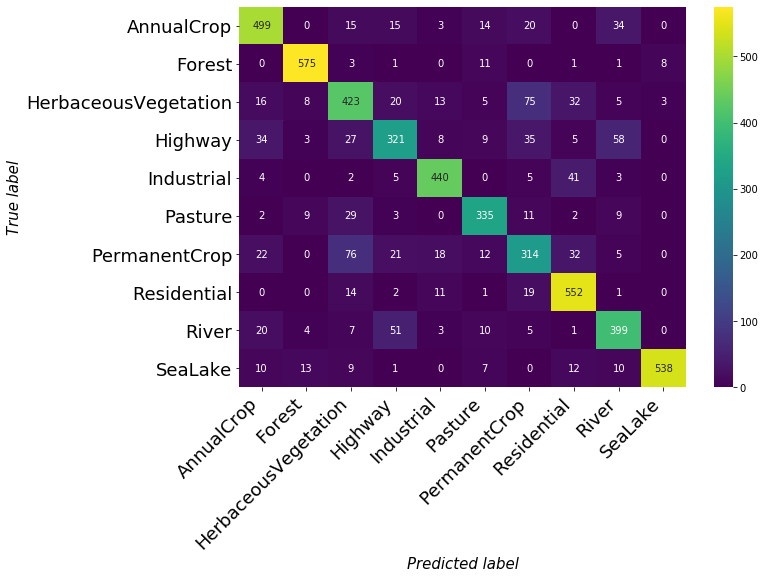

In [36]:
# lightGBM confusion matrix
lightgbm_combine_cm = confusion_matrix(RGB_labels_test, 
                                       lightgbm_combine.predict(RGB_dsift_test, 
                                                                num_iteration = lightgbm_combine.best_iteration_), 
                                       labels = labels)
model_eval.print_confusion_matrix(lightgbm_combine_cm, labels)

In [30]:
# try CatBoost model with combined dataset (another alternative GBM to XGBoost)
catboost_combine = catboost.CatBoostClassifier(
                            iterations = 10000, # arbitrarily large number since early stopping rounds used
                            depth = 7,
                            loss_function = "MultiClass",
                            eval_metric = 'MultiClass',
                            learning_rate = 0.05,
                            reg_lambda = 1,
                            thread_count = -1,
                            random_state = 423,
                            task_type = 'GPU',
                            logging_level = 'Silent'
                          )

eval_set = [(combine_val, combine_labels_val)]  

catboost_combine.fit( 
        combine_train, combine_labels_train, 
        eval_set = eval_set,
        early_stopping_rounds = 50,
        verbose = False
       )

catboost_combine_metrics = model_eval.compute_metrics(catboost_combine, RGB_dsift_test, RGB_labels_test)
catboost_combine_metrics

{'accuracy': 0.825925925925926,
 'f1_score': 0.8243909949591937,
 'precision': 0.8246222659917551,
 'recall': 0.825925925925926,
 'specificity': nan,
 'log_loss': 0.49145048566490585,
 'auc': 0.9827281325585789}

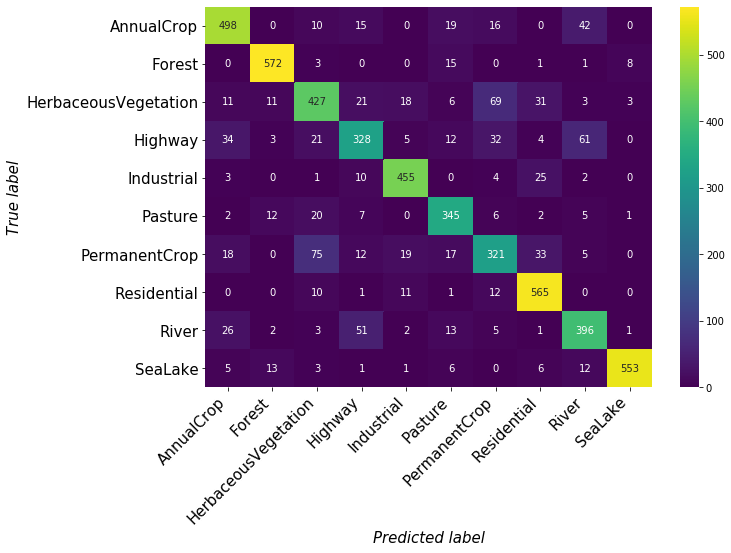

In [31]:
# CatBoost confusion matrix
catboost_combine_cm = confusion_matrix(RGB_labels_test, 
                                       catboost_combine.predict(RGB_dsift_test, 
                                                                ntree_end = catboost_combine.tree_count_), 
                                       labels = labels)
model_eval.print_confusion_matrix(catboost_combine_cm, labels, fontsize = 15, file = 'catboost_cm.png')

In [32]:
catboost_combine.best_iteration_  # best no. of trees for CatBoost

3258

In [29]:
# update CatBoost model structure with best no. of trees
catboost_update = catboost.CatBoostClassifier(
                            iterations = catboost_combine.best_iteration_, 
                            depth = 7,
                            loss_function = "MultiClass",
                            eval_metric = 'MultiClass',
                            learning_rate = 0.05,
                            reg_lambda = 1,
                            thread_count = -1,
                            random_state = 423,
                            task_type = 'GPU',
                            logging_level = 'Silent'
                          )

In [30]:
# stack prior models for new improved classifier
# uses logistic regression as 'meta-classifier' to model probability outputs from stacked models for final prediction
models = [catboost_update, RF_combine, nb_combine, logistic_combine, knn_combine]
stack = StackingClassifier(classifiers = models, 
                           meta_classifier = LogisticRegression(solver = 'lbfgs', multi_class = 'auto'), 
                           use_probas = True)
stack.fit(RGB_dsift_train, RGB_labels_train)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


StackingClassifier(average_probas=False,
          classifiers=[<catboost.core.CatBoostClassifier object at 0x7f0f5438f2b0>, RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_sam...owski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')],
          drop_last_proba=False,
          meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=False, use_probas=True, verbose=0)

In [31]:
# slight accuracy improvement over GBMs
stack_accuracy = accuracy_score(RGB_labels_test, stack.predict(RGB_dsift_test))
stack_accuracy

0.8333333333333334

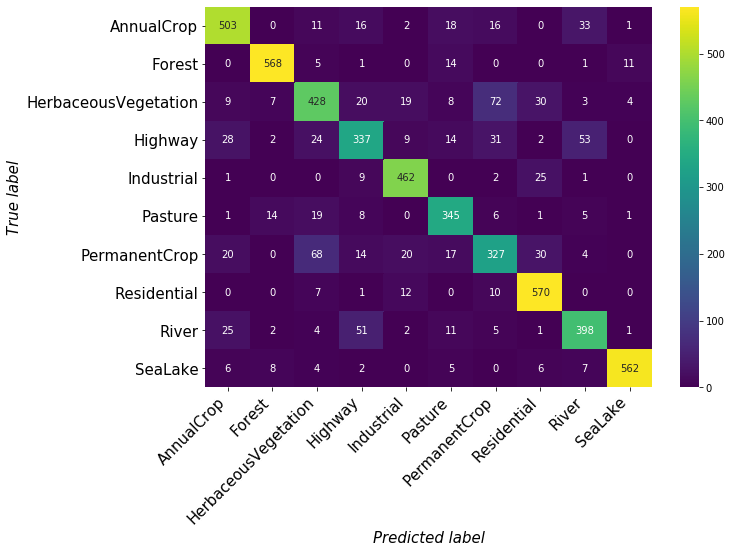

In [76]:
# stacked classifier confusion matrix
stack_cm = confusion_matrix(RGB_labels_test, stack.predict(RGB_dsift_test), labels = labels)
model_eval.print_confusion_matrix(stack_cm, labels, fontsize = 15, file = 'stack_cm.png')

In [32]:
# combine accuracies from all models into DataFrame
model_metrics = [gbm_combine_metrics, nb_combine_metrics, knn_combine_metrics, 
                 logistic_combine_metrics, tree_combine_metrics, RF_combine_metrics, 
                 extra_combine_metrics]
model_names = ['Gradient Boosting', 'Naive Bayes', 'kNN', 'Logistic Regression', 'Decision Tree', 
               'Random Forest', 'Extra Trees', 'Stacking']
accuracy_scores = [metrics['accuracy'] for metrics in model_metrics] + [stack_accuracy]
accuracies = pd.DataFrame({'Accuracy': accuracy_scores}, index = model_names).sort_values('Accuracy')
accuracies

,Accuracy
kNN,0.371667
Naive Bayes,0.531296
Decision Tree,0.550741
Logistic Regression,0.636667
Extra Trees,0.742222
Random Forest,0.748519
Gradient Boosting,0.807963
Stacking,0.833333


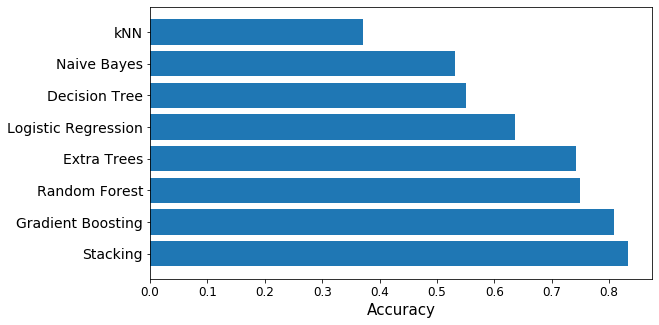

In [38]:
# bar plot of model accuracies
plt.figure(figsize = (9, 5))
plt.barh(accuracies.index[::-1], accuracies.Accuracy[::-1], color = 'tab:blue')
plt.xlabel('Accuracy', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)
plt.savefig('accuracy_scores.png', dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()